In [71]:
import requests
import io
import requests
import pandas as pd

# The API URL
url = "https://data.norges-bank.no/api/data/GOVT_GENERIC_RATES/B.7Y+6M+5Y+3Y+3M+12M+10Y.GBON+TBIL.?format=csv&startPeriod=2000-10-17&endPeriod=2024-10-17&locale=en"

# Send a GET request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load the CSV data into a pandas DataFrame
    csv_data = response.content.decode('utf-8')
    data = pd.read_csv(io.StringIO(csv_data), sep=';')

    # Display the first few rows of the data
    print(data.head())
else:
    print(f"Failed to retrieve data: {response.status_code}")

data = data[['Tenor', 'TIME_PERIOD','OBS_VALUE']].rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE':'Yield'})

import pandas as pd

# Assuming your current dataframe is named 'data', with columns: 'Tenor', 'TIME_PERIOD', 'OBS_VALUE'
# We'll pivot the dataframe to create a wide format where Tenor is in columns and TIME_PERIOD in the index.

wide_df = data.pivot(index='Date', columns='Tenor', values='Yield').reset_index()

norwegian_yields = wide_df[['Date', '3 months', '6 months', '12 months', '3 years', '5 years', '7 years', '10 years']]
norwegian_yields

norwegian_labels = ['3M', '6M', '1Y', '3Y', '5Y', '7Y', '10Y']
norwegian_yields['Date'] = pd.to_datetime(norwegian_yields['Date'])

norwegian_yields.set_index('Date', inplace=True)

# Drop rows with all NaN values and fill forward to ensure continuous data
norwegian_yields.dropna(how='all', inplace=True)
norwegian_yields.fillna(method='ffill', inplace=True)

# Resample data to quarterly frequency and include the last observation
yield_df_quarterly = norwegian_yields.resample('QE').last()

# Update the last date's yield values to today's date
today = pd.Timestamp(datetime.today().date())

# Check if the last date is earlier than today
if not yield_df_quarterly.index.empty and yield_df_quarterly.index[-1] > today:
    last_yields = yield_df_quarterly.iloc[-1]
    yield_df_quarterly.loc[today] = last_yields

# If today's date already exists in the DataFrame, keep the values intact
yield_df_quarterly.sort_index(inplace=True)  # Sort index to ensure correct date ordering

yield_df_quarterly = yield_df_quarterly.iloc[:-1,:].copy()

yield_df_quarterly

  FREQ Frequency TENOR    Tenor INSTRUMENT_TYPE   Instrument Type  DECIMALS  \
0    B  Business    3Y  3 years            GBON  Government bonds         3   
1    B  Business    3Y  3 years            GBON  Government bonds         3   
2    B  Business    3Y  3 years            GBON  Government bonds         3   
3    B  Business    3Y  3 years            GBON  Government bonds         3   
4    B  Business    3Y  3 years            GBON  Government bonds         3   

  Decimals TIME_PERIOD  OBS_VALUE  
0    Three  2019-01-02      1.050  
1    Three  2019-01-03      1.027  
2    Three  2019-01-04      1.010  
3    Three  2019-01-07      1.013  
4    Three  2019-01-08      1.051  


C:\Users\jonas\AppData\Local\Temp\ipykernel_25496\773173952.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  norwegian_yields.fillna(method='ffill', inplace=True)


Tenor,3 months,6 months,12 months,3 years,5 years,7 years,10 years
Date,,,,,,,
2019-03-31,1.086,1.127,1.192,1.255,1.334,1.438,1.601
2019-06-30,1.175,1.265,1.250,1.227,1.245,1.312,1.447
2019-09-30,1.361,1.314,1.312,1.283,1.226,1.205,1.222
2019-12-31,0.990,1.029,1.258,1.397,1.375,1.446,1.543
2020-03-31,0.143,0.172,0.203,0.394,0.505,0.656,0.862
2020-06-30,0.034,0.041,0.064,0.172,0.286,0.431,0.601
2020-09-30,-0.085,-0.081,-0.054,0.158,0.334,0.470,0.596
2020-12-31,0.015,0.021,0.060,0.421,0.656,0.827,0.942
2021-03-31,0.137,0.153,0.241,0.712,1.052,1.282,1.534


In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from fredapi import Fred
import dash
import dash_bootstrap_components as dbc
from dash import html, callback, Input, Output

# Initialize FRED API
FRED_API_KEY = '29f9bb6865c0b3be320b44a846d539ea'
fred = Fred(FRED_API_KEY)

# Define the observation period (e.g., last 10 years)
observation_start = (datetime.today() - timedelta(days=40 * 365)).strftime('%Y-%m-%d')  # 10 years ago

# List of maturities and their corresponding FRED series IDs
maturity_labels = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
series_ids = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5',
              'DGS7', 'DGS10', 'DGS20', 'DGS30']

# Fetch data for each series over the entire historical period
yield_data = {}
for series_id in series_ids:
    yield_data[series_id] = fred.get_series(series_id, observation_start=observation_start)

# # Combine all series into a single DataFrame
# yield_df = pd.DataFrame(yield_data)
# yield_df.index = pd.to_datetime(yield_df.index)

# # Drop rows with all NaN values and fill forward to ensure continuous data
# yield_df.dropna(how='all', inplace=True)
# yield_df.fillna(method='ffill', inplace=True)

# # Resample data to quarterly frequency and include the last observation
# yield_df_quarterly = yield_df.resample('QE').last()

# # Update the last date's yield values to today's date
# today = pd.Timestamp(datetime.today().date())

# # Check if the last date is earlier than today
# if not yield_df_quarterly.index.empty and yield_df_quarterly.index[-1] > today:
#     last_yields = yield_df_quarterly.iloc[-1]
#     yield_df_quarterly.loc[today] = last_yields

# # If today's date already exists in the DataFrame, keep the values intact
# yield_df_quarterly.sort_index(inplace=True)  # Sort index to ensure correct date ordering


In [9]:
yield_df = pd.DataFrame(yield_data)

In [11]:
yield_df

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
1984-10-29,NaN,9.65,10.18,10.55,11.30,11.56,11.79,11.89,11.95,11.84,11.75
1984-10-30,NaN,9.54,9.97,10.37,11.13,11.37,11.63,11.69,11.75,11.67,11.61
1984-10-31,NaN,9.35,9.84,10.26,11.09,11.36,11.59,11.70,11.79,11.71,11.64
1984-11-01,NaN,9.36,9.77,10.18,10.93,11.18,11.45,11.57,11.66,11.60,11.53
1984-11-02,NaN,9.34,9.81,10.17,10.96,11.20,11.46,11.58,11.66,11.63,11.55
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11,4.97,4.73,4.44,4.18,3.95,3.85,3.88,3.97,4.08,4.44,4.39
2024-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-15,4.93,4.73,4.42,4.18,3.95,3.86,3.86,3.93,4.03,4.37,4.32
2024-10-16,4.91,4.72,4.42,4.17,3.93,3.84,3.84,3.92,4.02,4.36,4.30


C:\Users\jonas\AppData\Local\Temp\ipykernel_25496\3818986616.py:11: FutureWarning: 'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.
  tenyear = fred.get_series('DGS10').resample('AS-JAN').first()


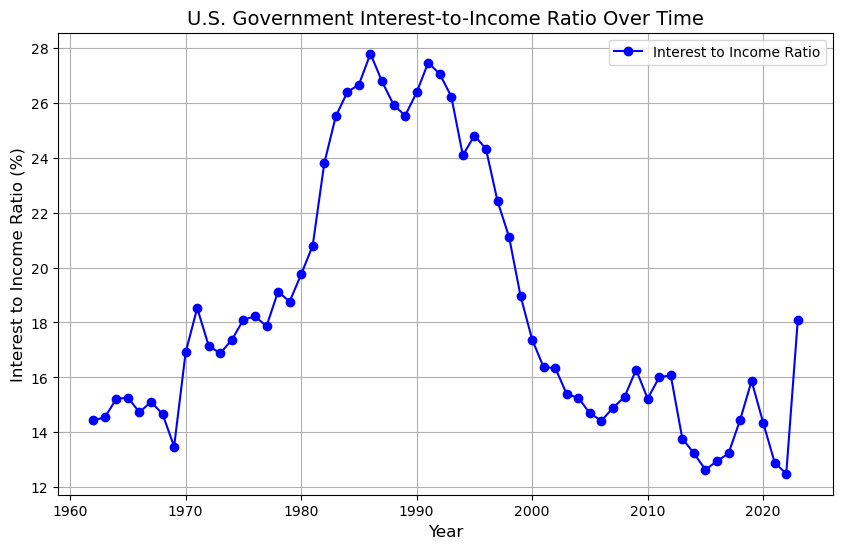

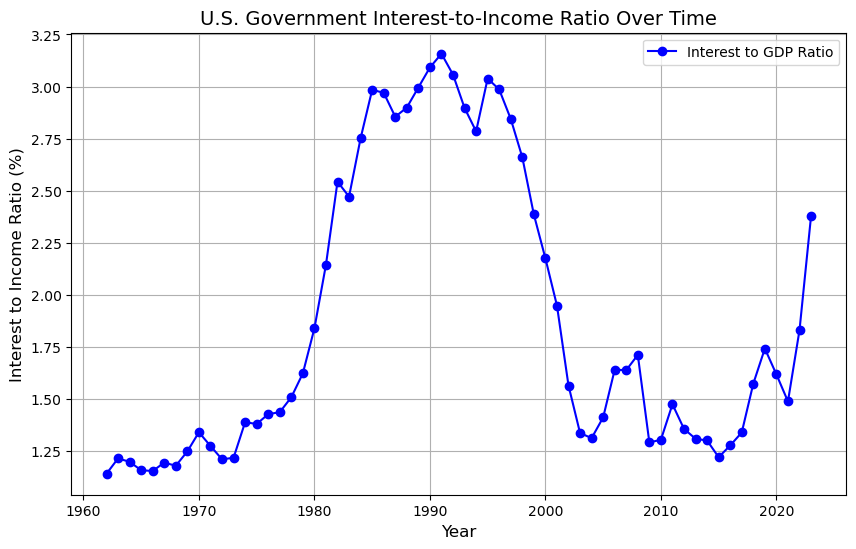

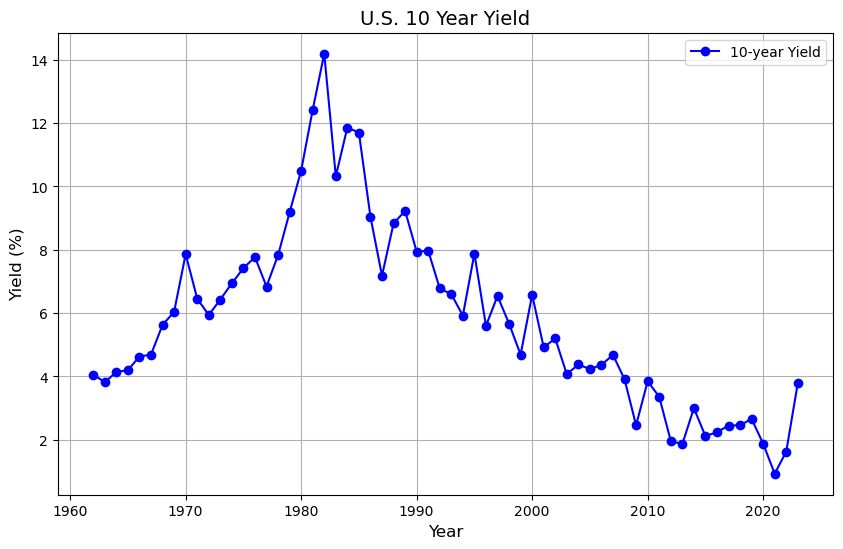

In [32]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve data from FRED
# Series ID for Interest Payments: FGEXPND
# Series ID for Government Receipts: FGRECPT
interest_payments = fred.get_series('A091RC1Q027SBEA')
government_revenue = fred.get_series('FGRECPT')
interesttogdp = fred.get_series('FYOIGDA188S')
tenyear = fred.get_series('DGS10').resample('AS-JAN').first()

# Convert the data into a DataFrame for easier handling
interest_df = pd.DataFrame(interest_payments, columns=['Interest Payments'])
revenue_df = pd.DataFrame(government_revenue, columns=['Total Revenue'])
interesttogdp_df = pd.DataFrame(interesttogdp, columns=['Interest to GDP'])
tenyear_df = pd.DataFrame(tenyear, columns=['10-year'])
# Merge the two datasets on the date index
df = pd.merge(interest_df, revenue_df, left_index=True, right_index=True)
df = pd.merge(df, interesttogdp_df,  left_index=True, right_index=True)
df = pd.merge(df, tenyear_df,  left_index=True, right_index=True)
# Convert the index to a datetime index and extract the year
df.index = pd.to_datetime(df.index).year

# Calculate the interest-to-income ratio
df['Interest to Income Ratio'] = ((df['Interest Payments'])/df['Total Revenue'])* 100

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Interest to Income Ratio'], label='Interest to Income Ratio', color='b', marker='o')

# Add titles and labels
plt.title('U.S. Government Interest-to-Income Ratio Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Interest to Income Ratio (%)', fontsize=12)

# Add a grid
plt.grid(True)

# Display the plot
plt.legend()
plt.show()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Interest to GDP'], label='Interest to GDP Ratio', color='b', marker='o')

# Add titles and labels
plt.title('U.S. Government Interest-to-Income Ratio Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Interest to Income Ratio (%)', fontsize=12)

# Add a grid
plt.grid(True)

# Display the plot
plt.legend()
plt.show()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['10-year'], label='10-year Yield', color='b', marker='o')

# Add titles and labels
plt.title('U.S. 10 Year Yield', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)

# Add a grid
plt.grid(True)

# Display the plot
plt.legend()
plt.show()


In [29]:
df['10-year']

Series([], Name: 10-year, dtype: float64)

In [27]:
fred.get_series('FYOIGDA188S')

1940-01-01    0.87367
1941-01-01    0.72926
1942-01-01    0.63392
1943-01-01    0.75289
1944-01-01    0.98865
               ...   
2019-01-01    1.74168
2020-01-01    1.61782
2021-01-01    1.48784
2022-01-01    1.82985
2023-01-01    2.37794
Length: 84, dtype: float64

In [31]:
fred.get_series('DGS10').resample('AS-JAN').first()


C:\Users\jonas\AppData\Local\Temp\ipykernel_25496\3120489769.py:1: FutureWarning: 'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.
  fred.get_series('DGS10').resample('AS-JAN').first()


1962-01-01    4.06
1963-01-01    3.82
1964-01-01    4.14
1965-01-01    4.20
1966-01-01    4.63
              ... 
2020-01-01    1.88
2021-01-01    0.93
2022-01-01    1.63
2023-01-01    3.79
2024-01-01    3.95
Freq: YS-JAN, Length: 63, dtype: float64

In [77]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import dash_bootstrap_components as dbc
from dash import html, callback, Input, Output
import requests
import io
import requests
import pandas as pd
#dash.register_page(__name__, path='/norwegian_yield_curve')
app = dash.Dash(__name__, use_pages=False)
# Norwegian bond maturities and the processed yield data from the provided CSV




# The API URL
url = "https://data.norges-bank.no/api/data/GOVT_GENERIC_RATES/B.7Y+6M+5Y+3Y+3M+12M+10Y.GBON+TBIL.?format=csv&startPeriod=2000-10-17&endPeriod=2024-10-17&locale=en"

# Send a GET request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load the CSV data into a pandas DataFrame
    csv_data = response.content.decode('utf-8')
    data = pd.read_csv(io.StringIO(csv_data), sep=';')

    # Display the first few rows of the data
    print(data.head())
else:
    print(f"Failed to retrieve data: {response.status_code}")

data = data[['Tenor', 'TIME_PERIOD','OBS_VALUE']].rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE':'Yield'})

import pandas as pd

# Assuming your current dataframe is named 'data', with columns: 'Tenor', 'TIME_PERIOD', 'OBS_VALUE'
# We'll pivot the dataframe to create a wide format where Tenor is in columns and TIME_PERIOD in the index.

wide_df = data.pivot(index='Date', columns='Tenor', values='Yield').reset_index()

norwegian_yields = wide_df[['Date', '3 months', '6 months', '12 months', '3 years', '5 years', '7 years', '10 years']]
norwegian_yields.rename(columns={'3 months' : '3M', '6 months':'6M', '12 months': '1Y', '3 years' : '3Y', '5 years': '5Y', '7 years':'7Y', '10 years':'10Y'}, inplace=True)

norwegian_labels = ['3M', '6M', '1Y', '3Y', '5Y', '7Y', '10Y']
norwegian_yields['Date'] = pd.to_datetime(norwegian_yields['Date'])

norwegian_yields.set_index('Date', inplace=True)

# Drop rows with all NaN values and fill forward to ensure continuous data
norwegian_yields.dropna(how='all', inplace=True)
norwegian_yields.fillna(method='ffill', inplace=True)

# Resample data to quarterly frequency and include the last observation
yield_df_quarterly = norwegian_yields.resample('6ME').last()

# Update the last date's yield values to today's date
today = pd.Timestamp(datetime.today().date())

# Check if the last date is earlier than today
if not yield_df_quarterly.index.empty and yield_df_quarterly.index[-1] > today:
    last_yields = yield_df_quarterly.iloc[-1]
    yield_df_quarterly.loc[today] = last_yields

# If today's date already exists in the DataFrame, keep the values intact
yield_df_quarterly.sort_index(inplace=True)  # Sort index to ensure correct date ordering

norwegian_yields = yield_df_quarterly.iloc[:-1,:].copy()

# Get the latest yields for the table
last_yields = yield_df_quarterly.iloc[-1]

# Create a static yield table
static_table_content = [
    html.Tr([html.Td('Maturity')] + [html.Td(maturity) for maturity in norwegian_labels]),  # Header row
    html.Tr([html.Td('Yield (%)')] + [html.Td(f"{last_yields[i]:.2f}") for i in norwegian_labels])  # Yield values
]

# Create the static yield table
static_yield_table = html.Table(
    static_table_content,
    style={'width': '100%', 'borderCollapse': 'collapse', 'border': '1px solid black'},
)

# Add header for the yields
yield_table_header = html.Div(f"Yields as of {today.date()}", style={'fontWeight': 'bold', 'marginBottom': '10px'})

# Define the layout of the app
app.layout = html.Div([
    html.H1("Norwegian Government Historical Yield Curve 3D Visualization"),

    # Static yield table
    html.Div([yield_table_header, static_yield_table], style={'padding': '10px', 'backgroundColor': '#f9f9f9', 
                                                               'borderRadius': '5px', 'marginBottom': '20px'}),
    
    # Date range picker
    dcc.DatePickerRange(
        id='date-picker-range',
        start_date=yield_df_quarterly.index.min().date(),  # Start date is the minimum in the data
        end_date=datetime.today().date(),  # End date is today
        display_format='YYYY-MM-DD',  # Format for displaying the date
        style={'marginBottom': '20px'}
    ),
    
    dcc.Graph(id='yield-curve-3d', config={'scrollZoom': True}, style={'height': '1000px'}),
])

@app.callback(
    Output('yield-curve-3d', 'figure'),
    [Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_graph(start_date, end_date):
    # Filter the data based on selected date range
    mask = (yield_df_quarterly.index >= start_date) & (yield_df_quarterly.index <= end_date)
    filtered_data = yield_df_quarterly.loc[mask]
    
    # Calculate the number of years in the selected date range
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    num_years = (end_date - start_date).days / 365.25
    
    # Determine tick frequency based on the number of years
    if num_years <= 1:
        tick_freq = '3M'  # 4 ticks per year (quarterly)
    elif 1 < num_years <= 5:
        tick_freq = '6M'  # 2 ticks per year (semi-annually)
    else:
        tick_freq = '1Y'  # 1 tick per year (annually)
    
    # Create the ticks based on the determined frequency
    x_ticks = pd.date_range(start=start_date, end=end_date, freq=tick_freq).to_list()
    
    # Include today's date in x_ticks if it isn't already
    if today not in x_ticks:
        x_ticks.append(today)

    x_ticks = sorted(x_ticks)  # Sort to maintain order
    x_tick_values = mdates.date2num(x_ticks)  # Convert to numerical format for plotting

    # Create the 3D surface plot
    fig = go.Figure(data=[go.Surface(
        z=filtered_data.T.values,  # Use filtered quarterly data
        x=mdates.date2num(filtered_data.index),  # Convert dates for plotting
        y=np.arange(len(norwegian_labels)), 
        colorscale='GnBu',  # Color scale
        colorbar_title='Yield (%)'
    )])

    # Update layout for the 3D plot
    fig.update_layout(
        title=f"Norwegian Yield Curve (3M to 10Y) from {start_date.date()} to {end_date.date()}",
        scene=dict(
            xaxis_title='Date',
            yaxis_title='Maturity',
            zaxis_title='Yield (%)',
            xaxis=dict(
                tickmode='array',
                tickvals=x_tick_values,  # Set the custom tick values
                ticktext=[d.strftime('%Y-%m-%d') for d in x_ticks],  # Formatted tick text
                backgroundcolor='white'  # Set background color to white
            ),
            yaxis=dict(
                tickvals=np.arange(len(norwegian_labels)), 
                ticktext=norwegian_labels,
                backgroundcolor='white'  # Set background color to white
            ),
            zaxis=dict(backgroundcolor='white')  # Set background color to white for z-axis
        ),
        scene_camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25),  # Controls the 3D view
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0)
        ),
        margin=dict(l=0, r=0, b=10, t=40),
        annotations=[
            dict(
                text="Data Source: Norges Bank",
                x=0.0,
                y=0.1,
                align="right",
                xref="paper",
                yref="paper",
                showarrow=False
            )
        ]
    )
    fig.update_layout(showlegend=False)
    fig.update_annotations(font=dict(family="Helvetica", size=12))
    
    return fig




import socket
from contextlib import closing


def find_free_port():
     with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
       s.bind(('', 0))
       return s.getsockname()[1]

if __name__ == '__main__':
    app.run_server(debug=True, port=find_free_port())


  FREQ Frequency TENOR    Tenor INSTRUMENT_TYPE   Instrument Type  DECIMALS  \
0    B  Business    3Y  3 years            GBON  Government bonds         3   
1    B  Business    3Y  3 years            GBON  Government bonds         3   
2    B  Business    3Y  3 years            GBON  Government bonds         3   
3    B  Business    3Y  3 years            GBON  Government bonds         3   
4    B  Business    3Y  3 years            GBON  Government bonds         3   

  Decimals TIME_PERIOD  OBS_VALUE  
0    Three  2019-01-02      1.050  
1    Three  2019-01-03      1.027  
2    Three  2019-01-04      1.010  
3    Three  2019-01-07      1.013  
4    Three  2019-01-08      1.051  


C:\Users\jonas\AppData\Local\Temp\ipykernel_25496\4122452739.py:58: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



C:\Users\jonas\AppData\Local\Temp\ipykernel_25496\4122452739.py:138: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

